# Get all data needed for causal inference project

## Set up

In [ ]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from entsoe import mappings, EntsoePandasClient
from entsoe.geo.utils import load_zones
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import os
import matplotlib.pyplot as plt
import warnings
import requests
from pandas import json_normalize
import geopandas as gpd
import shapely
import time


from scripts.utils import read_file, scale_font_latex
from scripts.countries import GEN_COLUMN_MAP, GEN_COLUMN_MAP_ALT, EUROPEAN_BZN

In [2]:
# Create necessary directories
os.makedirs("../data", exist_ok=True)
os.makedirs("../data/raw", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../data/processed/combined_data", exist_ok=True)
os.makedirs("../data/raw/price", exist_ok=True)
os.makedirs("../data/raw/generation", exist_ok=True)
os.makedirs("../data/raw/load", exist_ok=True)
os.makedirs("../data/raw/temperature", exist_ok=True)
os.makedirs("../data/raw/river", exist_ok=True)
os.makedirs("../data/raw/na", exist_ok=True)
os.makedirs("../data/raw/crossborderflow", exist_ok=True)
os.makedirs("../data/raw/renewable", exist_ok=True)

In [ ]:
# .env path
dotenv_path = f"../.env.txt"

# load up the entries as environment variables
load_dotenv(dotenv_path)

api_key = os.environ.get("api_key")
client = EntsoePandasClient(api_key=api_key, retry_count=30, retry_delay=30)

# END is the real end of the time span
# The API excludes the last entry therefore QUERY_END is added which is 2 days later

START = pd.Timestamp("20180101T00", tz="utc")
END = pd.Timestamp("20231231T23", tz="utc")
QUERY_END = pd.Timestamp("20240103T00", tz="utc")
years = f"{START.year}-{END.year}"


# in NEIGHBOURS[COUNTRY_CODE] "CH","GB","IT_NORD_FR" are not used
NEIGHBOURS = mappings.NEIGHBOURS
COUNTRY_CODE = "FR"
time_bzn_split = pd.Timestamp("20180930T21", tz="utc")
neighbours = [
    cc for cc in NEIGHBOURS[COUNTRY_CODE] if cc not in ["GB", "IT_NORD_FR", "CH"]
]

In [ ]:
# Paths of different data

paths = {
    "da_import": f"../data/raw/crossborderflow/da_import_{COUNTRY_CODE}_{years}.csv",
    "da_export": f"../data/raw/crossborderflow/da_export_{COUNTRY_CODE}_{years}.csv",
    "net_export": f"../data/raw/crossborderflow/net_export_{COUNTRY_CODE}_{years}.csv",
    "price": f"../data/raw/price/price_{COUNTRY_CODE}_{years}.csv",
    "neighbor_price_da": f"../data/raw/price/neighbor_price_da_{COUNTRY_CODE}_{years}.csv",
    "gas_price_raw": "../data/raw/price/Price+History_20241019_2220.xlsx",
    "gas_price": f"../data/raw/price/gas_price_{COUNTRY_CODE}_{years}.csv",
    "carbon_price": f"../data/raw/price/carbon_price_{COUNTRY_CODE}_{years}.csv",
    "carbon_price_raw": "../data/raw/price/carbonprice.csv",
    "gas_dependency": f"../data/raw/nrg_bal_peh_el_prod_by_fuel.tsv",
    "european_prices_da": f"../data/processed/european_prices_da.csv",
    "renew": f"../data/raw/renewable/renew_{COUNTRY_CODE}_{years}.csv",
    "load_da": f"../data/raw/load/load_da_{COUNTRY_CODE}_{years}.csv",
    "load_real": f"../data/raw/load/load_real_{COUNTRY_CODE}_{years}.csv",
    "generation": f"../data/raw/generation/gen_{COUNTRY_CODE}_{years}.csv",
    "generation_da": f"../data/raw/generation/gen_da_{COUNTRY_CODE}_{years}.csv",
    "res_load_da": f"../data/raw/res_load_da_{COUNTRY_CODE}_neighbours_{years}.csv",
    "na": f"../data/raw/na/nuclear_avail_{COUNTRY_CODE}_{years}.csv",
    "na_installed_cap": f"../data/raw/na/installed_capacity_production_type_{COUNTRY_CODE}_{years}.csv",
    "na_gen_unavail": f"../data/raw/na/gen_unvail_{COUNTRY_CODE}_{years}.csv",
    "temp_raw": "../data/raw/temperature/open-meteo.csv",
    "temp": f"../data/raw/temperature/temp_{COUNTRY_CODE}_{years}.csv",
    "temp_mean": f"../data/raw/temperature/temp_mean_{COUNTRY_CODE}_{years}.csv",
    "river_temp": f"../data/raw/river/river_temp_mean_{COUNTRY_CODE}_{years}.csv",
    "river_flow": f"../data/raw/river/river_flow_{COUNTRY_CODE}_{years}.csv",
    "FR_holiday_raw": "../data/raw/france_holiday.csv",
    "FR_holiday": "../data/processed/france_holiday.csv",
    "data_full": f"../data/processed/combined_data/data_full_{COUNTRY_CODE}_{years}.csv",
    "data_selected": f"../data/processed/combined_data/data_selected_{COUNTRY_CODE}_{years}.csv",
}


def adjust_de_bzn_split(df, start, end, time_of_split):
    """
    Adjusts the bidding zone split for Germany (DE_LU and DE_AT_LU) in the given DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to adjust.
    - start (pd.Timestamp): The start timestamp of the data.
    - end (pd.Timestamp): The end timestamp of the data.
    - time_of_split (pd.Timestamp): The timestamp when the bidding zone split occurred.

    Returns:
    - pd.DataFrame: The adjusted DataFrame with the DE_LU column updated and DE_AT_LU removed.
    """
    df.loc[start:time_of_split, "DE_LU"] = df.loc[start:time_of_split, "DE_LU"].fillna(
        0
    )
    df.loc[time_of_split:end, "DE_AT_LU"] = df.loc[
        time_of_split:end, "DE_AT_LU"
    ].fillna(0)
    df["DE_LU"] += df["DE_AT_LU"]
    df = df.drop("DE_AT_LU", axis=1)
    return df

## Get available Nuclear capacity

### Get total annuly installed nuclear capacity

In [ ]:
# get total annuly installed nuclear capacity

# manually downloaded from entsoe
# Downloaded from https://transparency.entsoe.eu/generation/r2/installedGenerationCapacityAggregation/show?name=&defaultValue=false&viewType=TABLE&areaType=BZN&atch=false&dateTime.dateTime=01.01.2015+00:00|UTC|YEAR&dateTime.endDateTime=01.01.2025+00:00|UTC|YEAR&area.values=CTY|10YFR-RTE------C!BZN|10YFR-RTE------C&productionType.values=B01&productionType.values=B25&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19#
installed_cap = pd.read_csv(paths["na_installed_cap"]).set_index("Production Type").T

# get hourly timestamp index
index = pd.date_range(start=START, end=END, freq="YS")
installed_cap.index = index
installed_cap = installed_cap.resample("1h").ffill()

# Create a new index for the remaining part of the year (hourly)
remaining_start = installed_cap.index[-1] + pd.DateOffset(
    hours=1
)  # Start the next day after the last year
remaining_end = END

# Create an hourly timestamp index for the remaining year
remaining_index = pd.date_range(start=remaining_start, end=remaining_end, freq="h")

# Create a DataFrame with the remaining hourly index
remaining_data = pd.DataFrame(index=remaining_index)

# Concatenate the existing data with the new hourly DataFrame
installed_cap = pd.concat([installed_cap, remaining_data])
installed_cap.ffill(inplace=True)


# select only necessary data and convert to int df
nuclear_cap = pd.DataFrame(installed_cap.loc[START:END, "Nuclear"].astype(int))
nuclear_cap = nuclear_cap.rename(columns={"Nuclear": "nuclear_cap"})

### Get unavailable capacity and calculate avail capacity

In [ ]:
# get unavailability of generation units
gen_unavail = client.query_unavailability_of_generation_units(
    COUNTRY_CODE,
    start=START,
    end=QUERY_END,
    docstatus=None,
    periodstartupdate=None,
    periodendupdate=None,
)
gen_unavail.to_csv(paths["na_gen_unavail"])

In [ ]:
# calculate nuclear availability:
# - only planned maintenance and
# - unplanned outages longer than a day
# - no cancelled maintanaces
# - started hours count as full hours
gen_unavail = read_file(
    paths["na_gen_unavail"], column_names={"Unnamed: 0": "timestamp"}
)
nuclear_unavail = gen_unavail[gen_unavail["plant_type"] == "Nuclear"]

df_unavail = pd.DataFrame(
    0, columns=["nuclear_unavail"], index=pd.date_range(start=START, end=END, freq="h")
)

df_data_nuclear = nuclear_unavail[
    nuclear_unavail["docstatus"] != "Cancelled"
].drop_duplicates()
df_data_nuclear["start"] = pd.to_datetime(df_data_nuclear["start"], utc=True)
df_data_nuclear["end"] = pd.to_datetime(df_data_nuclear["end"], utc=True)


# für jeden eintrag in df_data_nuclear:
# erstelle zeitraum mit unavail capacity = nominal power - avail_qty
for i in range(len(df_data_nuclear)):
    unavail = df_data_nuclear.iloc[i]

    df_tmp = pd.DataFrame(columns=["tmp"])
    df_tmp.loc[unavail["start"].replace(minute=0)] = float(
        unavail["nominal_power"]
    ) - float(unavail["avail_qty"])
    df_tmp.loc[unavail["end"].replace(minute=0)] = float(
        unavail["nominal_power"]
    ) - float(unavail["avail_qty"])

    df_tmp = df_tmp.resample("1h").ffill()

    df_tmp = df_tmp.iloc[:-1]  # dropping last row since end time should excluded

    # only include unplanned outages if longer than 24h -> otherwise should not effect da price.
    if (unavail["businesstype"] == "Unplanned outage") and (len(df_tmp) < 24):
        continue

    if len(df_tmp) > 2:
        df_unavail = df_unavail.join(df_tmp)

        df_unavail["nuclear_unavail"] = df_unavail["nuclear_unavail"].add(
            df_unavail["tmp"], fill_value=0
        )
        df_unavail.drop(columns=["tmp"], inplace=True)

# nuclear availability = installed capacity - unavailable capacity
df_nuclear_avail = df_unavail.join(nuclear_cap)
df_nuclear_avail["nuclear_avail"] = df_nuclear_avail["nuclear_cap"].sub(
    df_nuclear_avail["nuclear_unavail"]
)

# Limit to time frame and save
df_nuclear_avail.index.rename("timestamp", inplace=True)
df_nuclear_avail.truncate(before=START, after=END)
df_nuclear_avail.to_csv(paths["na"])

## Get Renewables, load and generation

In [ ]:
try:

    print("renewable da")
    renewable_da = (
        client.query_wind_and_solar_forecast(
            COUNTRY_CODE, start=START, end=QUERY_END, psr_type=None
        )
        .tz_convert(tz="utc")
        .rename(
            columns={
                "Solar": "solar_da",
                "Wind Offshore": "wind_off_da",
                "Wind Onshore": "wind_on_da",
            }
        )
    )
    renewable_da.index.name = "timestamp"

    print("load da")

    load_da = (
        client.query_load_forecast(COUNTRY_CODE, start=START, end=QUERY_END)
        .tz_convert(tz="utc")
        .rename(columns={"Unnamed: 0": "timestamp", "Forecasted Load": "load_da"})
    )
    load_da.index.name = "timestamp"

    print("load real")
    load_real = (
        client.query_load(COUNTRY_CODE, start=START, end=QUERY_END)
        .tz_convert(tz="utc")
        .rename(columns={"Unnamed: 0": "timestamp", "Actual Load": "load"})
    )
    load_real.index.name = "timestamp"
    generation_da = (
        client.query_generation_forecast(COUNTRY_CODE, start=START, end=QUERY_END)
        .tz_convert(tz="utc")
        .rename("generation_da")
    )
    generation_da.index.name = "timestamp"

    print("generation")
    generation = client.query_generation(
        COUNTRY_CODE, start=START, end=QUERY_END
    ).tz_convert(tz="utc")

except Exception as e:
    print(e)

renewable_da.truncate(before=START, after=END)
load_da.truncate(before=START, after=END)
load_real.truncate(before=START, after=END)
generation_da.truncate(before=START, after=END)


renewable_da.to_csv(paths["renew"])
load_da.to_csv(paths["load_da"])
load_real.to_csv(paths["load_real"])
generation_da.to_csv(paths["generation_da"])
generation.to_csv(paths["generation"])

renewable da
load da
load real
generation


#### calc RL of neighbours

In [ ]:
res_load = pd.DataFrame(index=pd.date_range(START, QUERY_END, freq="h", tz="utc"))
res_load.index.name = "timestamp"


for cc in neighbours + [COUNTRY_CODE]:
    print(cc)
    try:
        renewable_da = (
            client.query_wind_and_solar_forecast(
                cc, start=START, end=QUERY_END, psr_type=None
            )
            .tz_convert(tz="utc")
            .rename(
                columns={
                    "Solar": "solar_da",
                    "Wind Offshore": "wind_off_da",
                    "Wind Onshore": "wind_on_da",
                }
            )
        )
        renewable_da.index.name = "timestamp"
        load_da = (
            client.query_load_forecast(cc, start=START, end=QUERY_END)
            .tz_convert(tz="utc")
            .rename(columns={"Unnamed: 0": "timestamp", "Forecasted Load": "load_da"})
        )
        load_da = load_da.resample("1h").mean()
        renewable_da = renewable_da.resample("1h").mean()
        rl = pd.DataFrame(
            load_da["load_da"] - renewable_da.sum(axis=1), columns=["rl_" + cc]
        )
        res_load = res_load.join(rl)
    except:
        print("error in ", cc)


# adjust for bzn split in DE LU
res_load.loc[:time_bzn_split, "rl_DE_LU"] = res_load.loc[
    :time_bzn_split, "rl_DE_LU"
].fillna(0)
res_load.loc[time_bzn_split:, "rl_DE_AT_LU"] = res_load.loc[
    time_bzn_split:, "rl_DE_AT_LU"
].fillna(0)
res_load["rl_DE_LU"] += res_load["rl_DE_AT_LU"]
res_load = res_load.drop("rl_DE_AT_LU", axis=1)
res_load.truncate(before=START, after=END)
res_load.to_csv(paths["res_load_da"])

BE
DE_AT_LU
DE_LU
ES
IT_NORD
FR


## Get import/ export

In [ ]:
# scheduled commercial exchange.
# only commercial exchange was used. day ahead exchange only available after 2018.
da_import = pd.DataFrame(index=pd.date_range(START, QUERY_END, freq="h", tz="utc"))
da_import.index.name = "timestamp"
da_export = da_import.copy()


for neighbour in NEIGHBOURS[COUNTRY_CODE]:
    print(neighbour)

    try:
        # day-ahead export
        df_tmp = client.query_scheduled_exchanges(
            COUNTRY_CODE, neighbour, start=START, end=QUERY_END, dayahead=False
        )
        df_tmp = df_tmp.tz_convert(tz="utc")
        df_tmp.name = neighbour
        da_export = da_export.join(df_tmp)

        # day ahead import
        df_tmp = client.query_scheduled_exchanges(
            neighbour, COUNTRY_CODE, start=START, end=QUERY_END, dayahead=False
        )
        df_tmp = df_tmp.tz_convert(tz="utc")
        df_tmp.name = neighbour
        da_import = da_import.join(df_tmp)
    except Exception as e:
        print(e)
        print("error")
        continue

# IT_NORD_FR is not a valid neighbor of FR
if "IT_NORD_FR" in da_export.columns:
    da_export = da_export.drop("IT_NORD_FR", axis=1)

if "IT_NORD_FR" in da_import.columns:
    da_import = da_import.drop("IT_NORD_FR", axis=1)

# adjust for bzn split in DE
da_export = adjust_de_bzn_split(
    df=da_export, start=START, end=END, time_of_split=time_bzn_split
)
da_import = adjust_de_bzn_split(
    df=da_import, start=START, end=END, time_of_split=time_bzn_split
)

net_export = da_export - da_import
net_export["agg_net_export"] = net_export.sum(axis=1)

net_export.to_csv(paths["net_export"])

da_import.to_csv(paths["da_import"])
da_export.to_csv(paths["da_export"])

BE
CH
DE_AT_LU
DE_LU
ES
GB
IT_NORD
IT_NORD_FR

error


## Get price

In [ ]:
# French electricity price
price = client.query_day_ahead_prices(COUNTRY_CODE, start=START, end=QUERY_END)
price.index.set_names("timestamp", inplace=True)
price = price.to_frame()
price = price.rename(columns={0: COUNTRY_CODE})
price.index = price.index.tz_convert(tz="utc")
price.truncate(before=START, after=END)
price.to_csv(paths["price"])

In [ ]:
# day-ahead price of neighbors
n_prices_da = pd.DataFrame(index=pd.date_range(START, QUERY_END, freq="h", tz="utc"))
n_prices_da.index.name = "timestamp"


for cc in neighbours + [COUNTRY_CODE]:
    print(cc)
    df = client.query_day_ahead_prices(cc, start=START, end=QUERY_END).tz_convert("utc")
    df.name = cc
    df = df[~df.index.duplicated()]
    n_prices_da = n_prices_da.join(df)

# adjust for bzn split in DE
n_prices_da = adjust_de_bzn_split(
    df=n_prices_da, start=START, end=END, time_of_split=time_bzn_split
)

n_prices_da = n_prices_da.truncate(before=START, after=END)


n_prices_da = n_prices_da.rename(columns={cc: "price_da_" + cc for cc in neighbours})
n_prices_da.to_csv(paths["neighbor_price_da"])

BE
DE_AT_LU
DE_LU
ES
IT_NORD
FR


In [ ]:
# european day-ahead prices

time_it_split_1 = pd.Timestamp("20181231T22", tz="utc")
time_it_split_2 = pd.Timestamp("20201231T22", tz="utc")

time_currency_PLN = pd.Timestamp("20191119T22", tz="utc")
time_currency_RON = pd.Timestamp("20210617T21", tz="utc")

# Constant exchange rates
PLNToEUR = 0.23
RONToEUR = 0.21

# get prices
european_prices_da = pd.DataFrame(
    index=pd.date_range(START, QUERY_END, freq="h", tz="utc")
)
european_prices_da.index.name = "timestamp"
# european_bzn.remove("AT")
for cc in EUROPEAN_BZN:
    print(cc)
    df = client.query_day_ahead_prices(cc, start=START, end=QUERY_END).tz_convert("utc")
    df.name = cc
    df = df[~df.index.duplicated()]
    european_prices_da = european_prices_da.join(df)

# Correct for different currencies
european_prices_da.loc[:time_currency_PLN, "PL"] = (
    european_prices_da.loc[:time_currency_PLN, "PL"] * PLNToEUR
)
european_prices_da.loc[:time_currency_RON, "RO"] = (
    european_prices_da.loc[:time_currency_RON, "RO"] * RONToEUR
)
# Correct for italian bzn changes
bzn_it_split_1 = ["IT_ROSN", "IT_BRNN", "IT_FOGN", "IT_PRGP", "IT_SUD"]
bzn_it_split_2 = ["IT_ROSN", "IT_SUD"]
european_prices_da.loc[:time_it_split_1, "IT_SUD"] = european_prices_da.loc[
    :time_it_split_1, bzn_it_split_1
].mean(axis=1)
european_prices_da.loc[
    time_it_split_1 + pd.Timedelta(hours=1) : time_it_split_2, "IT_SUD"
] = european_prices_da.loc[
    time_it_split_1 + pd.Timedelta(hours=1) : time_it_split_2, bzn_it_split_2
].mean(
    axis=1
)
european_prices_da.loc[time_it_split_2 + pd.Timedelta(hours=1) :, "IT_SUD"] = (
    european_prices_da.loc[
        time_it_split_2 + pd.Timedelta(hours=1) :, ["IT_SUD", "IT_CALA"]
    ].mean(axis=1)
)
# Correct for DE_LU, DE_AT_LU bzn change
european_prices_da.loc[:time_bzn_split, "DE_LU"] = european_prices_da.loc[
    :time_bzn_split, "DE_AT_LU"
]

european_prices_da.drop(
    columns=["IT_ROSN", "IT_BRNN", "IT_FOGN", "IT_PRGP", "IT_CALA", "DE_AT_LU"],
    inplace=True,
)
european_prices_da.index = pd.to_datetime(european_prices_da.index)

# Save the DataFrame to a CSV file
european_prices_da.to_csv(paths["european_prices_da"], index=True)

AT
BE
CZ
HR
DK_1
DK_2
EE
FI
FR
DE_LU


Connection Error, retrying in 30 seconds


DE_AT_LU
HU
IT_SICI


Connection Error, retrying in 30 seconds


IT_CSUD
IT_CNOR
IT_SUD


Connection Error, retrying in 30 seconds
Connection Error, retrying in 30 seconds
Connection Error, retrying in 30 seconds


IT_SARD


Connection Error, retrying in 30 seconds


IT_NORD
IT_CALA
IT_ROSN
IT_BRNN
IT_FOGN


Connection Error, retrying in 30 seconds


IT_PRGP
LV


Connection Error, retrying in 30 seconds


LT


Connection Error, retrying in 30 seconds


NL


Connection Error, retrying in 30 seconds


NO_1
NO_2
NO_3
NO_4
NO_5
PL


Connection Error, retrying in 30 seconds


PT
RO
SK
SI
ES


Connection Error, retrying in 30 seconds


SE_1


Connection Error, retrying in 30 seconds


SE_2
SE_3
SE_4


## Get fuel prices

### Carbon price

annually data from https://carbonpricingdashboard.worldbank.org/compliance/price  from 1991 to 2022</br>
unit = US$/tCO2e

In [ ]:
carbon = pd.read_csv(paths["carbon_price_raw"], sep=";")
carbon["timestamp"] = pd.to_datetime(carbon["Category"].astype(str)).dt.tz_localize(
    tz="utc"
)
carbon.set_index("timestamp", inplace=True)
carbon.drop("Category", axis="columns", inplace=True)
carbon.replace(",", ".", regex=True, inplace=True)
carbon = carbon.astype(float)

# convert to EUR/tCO2e:
# 1 Dollar = 0,9300 EUR on 07.05.24 https://www.finanzen.net/waehrungsrechner/us-dollar_euro
carbon *= 0.93

# tax and ets needs to be added https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-du-climat-2023/en/17-carbon-pricing-around-the-world
# https://www.oecd.org/tax/tax-policy/carbon-pricing-france.pdf
carbon_price = carbon["EU ETS"] + carbon["France carbon tax"]
carbon_price.name = "carbon_price"

# ffill to hourly data.
carbon_price = carbon_price.resample("1h").ffill()

carbon_price = carbon_price.truncate(before=START, after=END)

carbon_price.to_csv(paths["carbon_price"])

### Gas price



In [ ]:
# Source:
# The gas price data was obtained from the TTF daily futures. The TTF daily futures provide daily values. Missing daily gas prices were interpolated.
# unit = EUR/MWh
gas_price = pd.read_excel(paths["gas_price_raw"], skiprows=18)
gas_price.rename(
    columns={"Exchange Date": "timestamp", "Close": "gas_price"}, inplace=True
)
gas_price = gas_price.filter(items=["timestamp", "gas_price"])
# Make timestamp into idx
gas_price.set_index("timestamp", inplace=True)
gas_price.index = pd.to_datetime(gas_price.index).tz_localize(tz="utc")

# add missing dates, end is increased by one day to get all hours of the last day
full_date_range = pd.date_range(
    start=START, end=END + pd.Timedelta(value=1, unit="d"), freq="D"
)
gas_price = gas_price.reindex(full_date_range)
gas_price.index.name = "timestamp"


# interpolate prices
gas_price["gas_price"] = gas_price["gas_price"].interpolate(method="linear")
# if any NaN remains (start/end) use ffill and bfill
gas_price["gas_price"] = gas_price["gas_price"].ffill()
gas_price["gas_price"] = gas_price["gas_price"].bfill()
# convert to hourly and ffil hourly data
gas_price = gas_price.resample("1h").ffill()
gas_price.truncate(before=START, after=END)
# Some kind of gas_price conversion
gas_price.to_csv(paths["gas_price"])

## Temperature

### get area mean temperature from open meteo

#### create grid point coordinates

In [ ]:
def create_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:29902"):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    see https://james-brennan.github.io/posts/fast_gridding_geopandas/

    Parameters
    ----------
    gdf : GeoDataFrame, optional
        Geodataframe to cover with grid. The default is None.
    bounds : list, optional
        List of bounds in the form [xmin, ymin, xmax, ymax]. The default is None.
    n_cells : int, optional
        Number of cells in the grid. The default is 10.
    overlap : bool, optional
        If True, the grid will overlap with the geodataframe. The default is False.
    crs : str, optional
        Coordinate reference system. The default is "EPSG:29902".
    """

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    # get cell size
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        cells = cells.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return cells

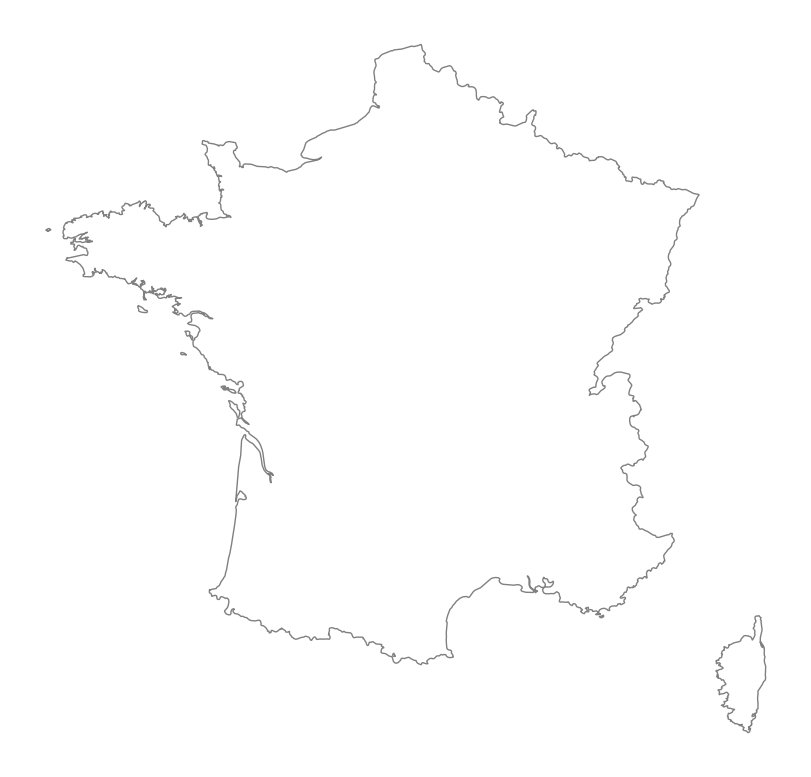

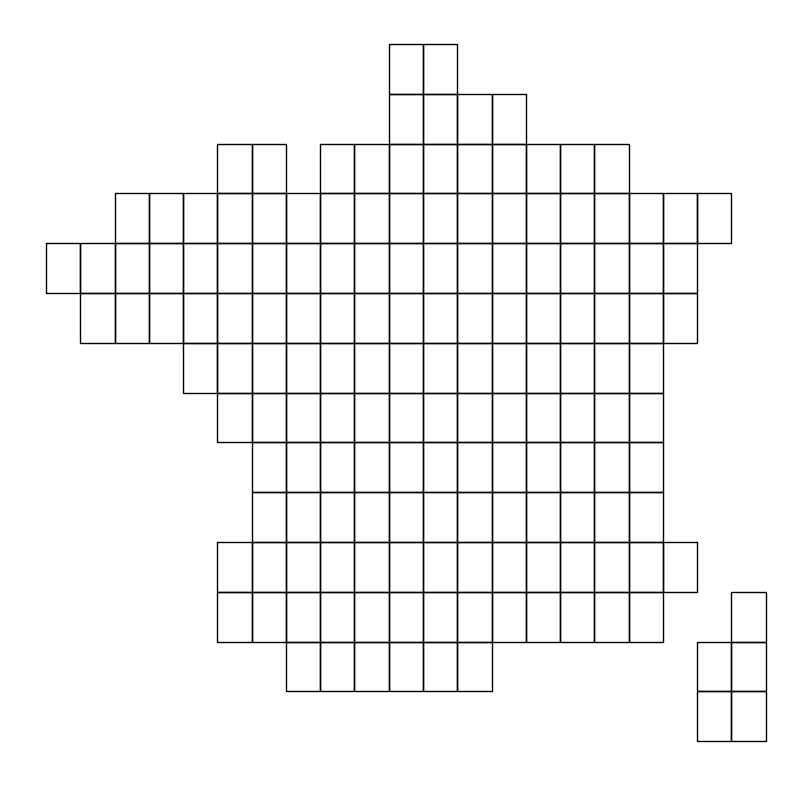

In [ ]:
scale_font_latex(1.5)
fig, ax = plt.subplots(1, 1, figsize=(8, 9), layout="constrained")

time_point = pd.Timestamp(
    "20200101"
)  # is only used to get correct bidding zones at this time. does nothing with values
zones = [COUNTRY_CODE]
geo_df = load_zones(zones, time_point)
crs = geo_df.crs

geo_df.plot(ec="gray", fc="none", figsize=(10, 10), ax=ax)
ax.axis(False)
fig.savefig("../reports/figures/french_temp_map.pdf", bbox_inches="tight")

gr = create_grid(geo_df, n_cells=20, overlap=True, crs=crs)
fig, ax = plt.subplots(1, 1, figsize=(8, 9), layout="constrained")
gr.plot(fc="none", ec="black", ax=ax)
ax.axis(False)
fig.savefig("../reports/figures/french_temp_grid.pdf", bbox_inches="tight")

coordinates = gr.get_coordinates().drop_duplicates()
long = coordinates["x"].to_list()
lat = coordinates["y"].to_list()

#### Get data for each coordinate point from open meteo

In [ ]:
def querry_temperature(start, end, latitude, longitude, column_prefix):
    """
    Query temperature data from Open-Meteo API and return a DataFrame.
    Parameters:
        - start: Start date as a Timestamp.
        - end: End date as a Timestamp.
        - latitude: Latitude of the location.
        - longitude: Longitude of the location.
        - column_prefix: Prefix for the column names in the returned DataFrame.
    Returns:
        - DataFrame with temperature data.
    """


    # Setup the Open-Meteo API client with cache and retry on error

    cache_session = requests_cache.CachedSession(".cache", expire_after=-1)

    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)

    openmeteo = openmeteo_requests.Client(session=retry_session)


    # Make sure all required weather variables are listed here

    # The order of variables in hourly or daily is important to assign them correctly below

    url = "https://archive-api.open-meteo.com/v1/archive"


    start_str = str(start).split(" ")[0]

    end_str = str(end).split(" ")[0]

    tz = "UTC"  # "Europe/Paris"

    params = {

        "latitude": latitude,

        "longitude": longitude,

        "start_date": start_str,

        "end_date": end_str,

        "hourly": "temperature_2m",

        "timezone": tz,

    }

    responses = openmeteo.weather_api(url, params=params)


    if end.hour != 23:  # set hour to end of day

        end += pd.Timedelta(value=23 - end.hour, unit="h")


    hourly_dataframe = pd.DataFrame(index=pd.date_range(start, end, freq="h", tz="utc"))

    hourly_dataframe.index.name = "timestamp"


    for i, response in enumerate(responses):

        # Process hourly data. The order of variables needs to be the same as requested.

        hourly = response.Hourly()

        hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()


        hourly_dataframe[str(column_prefix) + f"{i}"] = hourly_temperature_2m

    return hourly_dataframe

In [ ]:
# split locations in n chunks to avoid to long url error by api
start = START
end = END
n = int(np.ceil(len(lat) / 100))
latitude = np.array_split(lat, n)
longitude = np.array_split(long, n)
temperature = pd.DataFrame(index=pd.date_range(start, end, freq="h", tz="utc"))
temperature.index.name = "timestamp"
for i in range(n):
    temperature = temperature.join(
        # column prefix to avoid same column names
        querry_temperature(
            start=start,
            end=end,
            latitude=latitude[i],
            longitude=longitude[i],
            column_prefix=i,
        )
    )
    time.sleep(60)  # to avoid api minute limiti

temperature_mean = pd.DataFrame(temperature.mean(axis=1), columns=["temp_mean"])

temperature_mean.to_csv(paths["temp_mean"])

## River data

### River Temperature
data from https://hubeau.eaufrance.fr/page/api-temperature-continu#/ <br>

#### exploration

<Response [200]>


<Axes: >

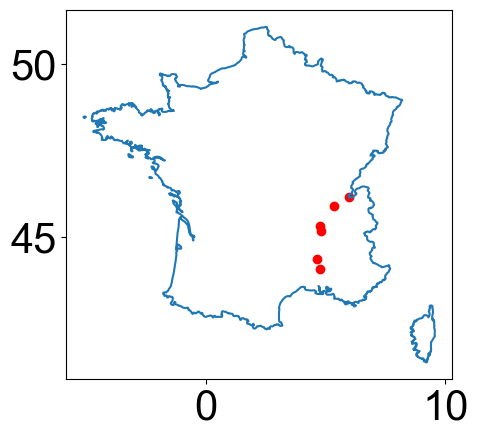

In [ ]:
# get stations for river code

url = "https://hubeau.eaufrance.fr/api/v1/temperature/station?code_cours_eau=V---0000&exact_count=true&format=json&size=20"
response = requests.get(url)
print(response)
# print(response.text)

data = response.json()
stations_df = json_normalize(data, "data")
stations = stations_df["code_station"]

fig, ax = plt.subplots(
    1,
    1,
)

gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude),
    crs="EPSG:4326",
)
time = pd.Timestamp("20200101")
geo_df = load_zones(["FR"], time)
geo_df = geo_df.to_crs(gdf.crs)

gdf.plot(ax=ax, color="red")
geo_df.boundary.plot(ax=ax)

#### get data

In [ ]:
def get_river_temp_stations(river_code):
    """get all measuring stations for one river
    Parameters:
        - river_code: code of the river
    Returns:
        - stations_df: DataFrame with all measuring stations for the river
    """

    url = f"https://hubeau.eaufrance.fr/api/v1/temperature/station?code_cours_eau={river_code}&exact_count=true&format=json&size=10000"
    response = requests.get(url)
    print(response)

    data = response.json()
    if data["data"] == []:
        print(f"no stations for river {river_code}")
        return None
    stations_df = json_normalize(data, "data")
    return stations_df["code_station"]


def get_river_temp(station, year):
    """for each station get hourly temperature data for one year
    Parameters:
        - station: code of the station
        - year: year of the data
    Returns:
        - temp_series: Series with hourly temperature data for the station"""

    url = f"https://hubeau.eaufrance.fr/api/v1/temperature/chronique?code_station={station}&date_debut_mesure={year}-01-01&date_fin_mesure={year+1}-01-01&size=20000"
    response = requests.get(url)
    print(response)
    data = response.json()
    if data["data"] == []:
        print(f"no data for station {station} in {year}-{year+1}")
        return None

    df = json_normalize(data, "data")
    df["timestamp"] = pd.to_datetime(
        df["date_mesure_temp"] + df["heure_mesure_temp"], format="%Y-%m-%d%H:%M:%S"
    )
    df = df.set_index("timestamp")
    df = df.tz_localize(
        tz="Europe/Paris", nonexistent="NaT", ambiguous="NaT"
    ).tz_convert(tz="utc")
    df = df[~df.index.duplicated()]  # drop duplicated indices

    temp_series = df["resultat"].resample("1h").mean()
    temp_series.name = station
    return temp_series


# river codes
rivers = {
    "rhone": "V---0000",
    "garonne": "O---0000",
    "dordogne": "P---0000",
    "vienne": " L---0060",
    "loire": "----0000",
    "rhein": "A---0012",
    "seine": "----0010",
    "mosel": "A---0060",
    "maas": "B---0000",
}

In [ ]:
# calc mean river temperature for all rivers with nuclear power plants nearby


# data is often scarse e.g. for le rhone only data for 3 stations available in only 2015,2016,2023.
river_codes = rivers.values()
river_temp_df = pd.DataFrame(index=pd.date_range(START, END, freq="h", tz="utc"))
river_temp_df.index.name = "timestamp"

for river in river_codes:
    print(river)
    frames = []
    stations = get_river_temp_stations(river)
    if stations is None:
        continue
    for year in range(2015, 2024):
        start = pd.Timestamp(f"{year}0101", tz="utc")
        end = pd.Timestamp(f"{year+1}0101", tz="utc")
        station_df = pd.DataFrame(index=pd.date_range(start, end, freq="h", tz="utc"))
        station_df.index.name = "timestamp"

        for station in stations:
            # print(year)
            s_tmp = get_river_temp(station=station, year=year)
            if s_tmp is None:
                continue
            station_df = station_df.join(s_tmp)
        frames.append(station_df)
    stations_total_time = pd.concat(frames)
    df_tmp = stations_total_time.mean(skipna=True, axis=1)
    df_tmp.name = river

    # mean temperature for each river
    river_temp_df = river_temp_df.join(df_tmp)

# mean temperature of all rivers
river_temp_total = river_temp_df.mean(skipna=True, axis=1)
river_temp_total = river_temp_total[
    ~river_temp_total.index.duplicated()
]  # drop duplicated indices
river_temp_total.name = "river_temp"

river_temp_total.to_csv(paths["river_temp"])

### river volumen flow

data from https://hubeau.eaufrance.fr/page/api-hydrometrie#/hydrometrie/observations <br>
unit is l/s für Durchflusssätze (Dip um 1000 in m3/s). time in utc

In [ ]:
def get_river_flow_stations(river_code):
    """get measuring stations for one river
    Parameters:
        - river_code: code of the river
    Returns:
        - stations_df: DataFrame with all measuring stations for the river
    """

    url = f"https://hubeau.eaufrance.fr/api/v1/hydrometrie/referentiel/stations?code_cours_eau={river_code}&format=json&size=10000"

    for reconnecting_times in range(100):
        response = requests.get(url)
        print(response)
        if response.status_code == 500:
            print("sever error 500: retry ", reconnecting_times)
            time.sleep(20)
        else:
            break

    data = response.json()
    if data["data"] == []:
        print(f"no stations for river {river_code}")
        return None
    stations_df = json_normalize(data, "data")
    return stations_df["code_station"]


def get_river_flow(station_code):
    """get flow rate for one station
    Parameters:
        - station_code: code of the station
    Returns:
        - temp_series: Series with hourly flow rate data for the station
    """

    # added one year to end date to get all days of the last year
    start_year = START.year
    end_year = END.year + 1
    url = f"https://hubeau.eaufrance.fr/api/v1/hydrometrie/obs_elab?code_entite={station_code}&date_debut_obs_elab={start_year}-01-01&date_fin_obs_elab={end_year}-01-01&size=20000"

    for reconnecting_times in range(100):
        response = requests.get(url)
        print(response)
        if response.status_code == 500:
            print("sever error 500: retry ", reconnecting_times)
            time.sleep(20)
        else:
            break
    data = response.json()
    if data["data"] == []:
        print(f"no data for station {station}")
        return None

    df = json_normalize(data, "data")
    df["timestamp"] = pd.to_datetime(df["date_obs_elab"], format="%Y-%m-%d")
    df = df.set_index("timestamp")
    df = df.tz_localize("utc")
    df = df[~df.index.duplicated()]  # drop duplicated indices

    temp_series = df["resultat_obs_elab"].resample("1h").ffill()
    temp_series.name = station_code
    return temp_series

In [ ]:
# calc mean river temperature for all rivers with npp nearby
import time

river_codes = rivers.values()
river_flow_mean = pd.DataFrame(index=pd.date_range(START, END, freq="h", tz="utc"))
river_flow_mean.index.name = "timestamp"

for river in river_codes:
    print(river)
    station_codes = get_river_flow_stations(river)

    if station_codes is None:
        continue
    frames = []
    station_df = pd.DataFrame(index=pd.date_range(START, END, freq="h", tz="utc"))
    station_df.index.name = "timestamp"

    for station_code in station_codes:
        s_tmp = get_river_flow(station_code=station_code)
        if s_tmp is None:
            continue
        station_df = station_df.join(s_tmp)

    df_tmp = station_df.mean(skipna=True, axis=1)
    df_tmp.name = river

    # mean flow rate of each river
    river_flow_mean = river_flow_mean.join(df_tmp)


# drop duplicated indices
river_flow_mean = river_flow_mean[~river_flow_mean.index.duplicated()]
river_flow_mean = river_flow_mean.rename(
    columns={v: "river_flow_" + k for k, v in rivers.items()}
)

# mean flow rate of all rivers
river_flow_mean["river_flow_mean"] = river_flow_mean.mean(axis=1)

river_flow_mean.to_csv(paths["river_flow"])

### Public holidays

In [ ]:
# data from https://www.data.gouv.fr/en/datasets/jours-feries-en-france/
holidays = pd.read_csv(paths["FR_holiday_raw"])
holidays = holidays[
    holidays["zones"]
    == "Métropole|Alsace-Moselle|Guadeloupe|Guyane|Martinique|Mayotte|Nouvelle-Calédonie|La Réunion|Polynésie Française|Saint-Barthélémy|Saint-Martin|Wallis-et-Futuna|Saint-Pierre-et-Miquelon"
]
holidays["timestamp"] = pd.to_datetime(holidays["date"]).dt.tz_localize(tz="utc")
holidays = holidays.drop("date", axis=1).set_index("timestamp")
holidays = holidays.loc[START:END]
holidays.to_csv(paths["FR_holiday"])

## Merge all data into one df

In [ ]:
def read_generation(path):
    """read generation data from csv file and rename columns to match the column names in the database
    unnessecary complicated because some bidding zone have multiindex and others not
    Parameters:
        -path: path to the csv file
    Returns:
        - generation: DataFrame with generation data
    """

    # test read file to check if multi index, disable warnings for test read

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        test = pd.read_csv(path, nrows=3)

        is_multi_idx = (

            type(test.iloc[0, 1]) == str

        )  # pick first element and chekc if string. Not really reliable?


    if is_multi_idx:

        generation = pd.read_csv(path, header=[0, 1]).rename(

            columns={"Unnamed: 0_level_0": "timestamp", "Unnamed: 0_level_1": ""}
        )

        generation["timestamp"] = pd.to_datetime(generation["timestamp"], utc=True)

        generation = generation.set_index("timestamp")

        generation.columns = [

            GEN_COLUMN_MAP[" ".join(col).strip()] for col in generation.columns.values

        ]
    else:

        generation = pd.read_csv(path, header=[0]).rename(

            columns={"Unnamed: 0": "timestamp"}
        )

        generation["timestamp"] = pd.to_datetime(generation["timestamp"], utc=True)

        generation = generation.set_index("timestamp").rename(

            columns=GEN_COLUMN_MAP_ALT
        )

        # generation.columns = [GEN_COLUMN_MAP_ALT[' '.join(col).strip()] for col in generation.columns.values]

    return generation



## add ramps: ramp(t) = f(t)-f(t-1)
def ramp(df, column):

    return df[column] - df[column].shift(periods=1, freq="h")



def calc_ramps(df):
    """calculate ramps and name them according to the column names
    Parameters:
        - df: original DataFrame
    Returns:
        - df: DataFrame with ramps
    """


    for column in df.columns:
        if "gen" in column:

            df[column.replace("gen", "ramp")] = ramp(df, column)

        elif "da" in column and column != "price_da":

            df[column + "_ramp"] = ramp(df, column)

        elif ("rl_" in column) & ("cutoff" not in column):

            df[column + "_ramp"] = ramp(df, column)
    return df



# assign calender features:



def assign_quarters(x):

    if x in [1, 2, 3]:

        return 0

    elif x in [4, 5, 6]:

        return 1

    elif x in [7, 8, 9]:

        return 2

    elif x in [10, 11, 12]:

        return 3



def assign_season(x):

    if x in [3, 4, 5]:

        return 0

    elif x in [6, 7, 8]:

        return 1

    elif x in [9, 10, 11]:

        return 2

    elif x in [12, 1, 2]:

        return 3



def assign_quarter_of_day(x):

    if x in range(0, 6):

        return 0

    elif x in range(6, 12):

        return 1

    elif x in range(12, 18):

        return 2

    elif x in range(18, 24):

        return 3

In [ ]:
# load all data and merge into one dataframe
net_export = (
    pd.read_csv(paths["net_export"], parse_dates=["timestamp"])
    .set_index("timestamp")
    .rename(columns={cc: COUNTRY_CODE + "->" + cc for cc in NEIGHBOURS[COUNTRY_CODE]})
)
da_import = (
    pd.read_csv(paths["da_import"], parse_dates=["timestamp"])
    .set_index("timestamp")
    .rename(columns=lambda x: COUNTRY_CODE + "<-" + x)
)
da_export = (
    pd.read_csv(paths["da_export"], parse_dates=["timestamp"])
    .set_index("timestamp")
    .rename(columns=lambda x: COUNTRY_CODE + "<-" + x)
)
price = (
    pd.read_csv(paths["price"], parse_dates=["timestamp"])
    .set_index("timestamp")
    .rename(columns={COUNTRY_CODE: "price_da"})
)
n_price = pd.read_csv(paths["neighbor_price_da"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)
carbon_price = pd.read_csv(paths["carbon_price"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)
gas_price = pd.read_csv(paths["gas_price"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)
renew = (
    pd.read_csv(paths["renew"])
    .rename(
        columns={
            "Unnamed: 0": "timestamp",
            "Solar": "solar_da",
            "Wind Offshore": "wind_off_da",
            "Wind Onshore": "wind_on_da",
        }
    )
    .set_index("timestamp")
)
load_da = (
    pd.read_csv(paths["load_da"])
    .rename(columns={"Unnamed: 0": "timestamp", "Forecasted Load": "load_da"})
    .set_index("timestamp")
)
load_real = (
    pd.read_csv(paths["load_real"])
    .rename(columns={"Unnamed: 0": "timestamp", "Actual Load": "load"})
    .set_index("timestamp")
)
res_load_da = pd.read_csv(paths["res_load_da"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)
holidays = pd.read_csv(paths["FR_holiday"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)
generation_da = pd.read_csv(
    paths["generation_da"], parse_dates=["timestamp"]
).set_index("timestamp")
generation = read_generation(paths["generation"])

na = pd.read_csv(paths["na"], parse_dates=["timestamp"]).set_index("timestamp")

temperature = pd.read_csv(paths["temp_mean"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)
river_temp = (
    pd.read_csv(paths["river_temp"], parse_dates=["timestamp"])
    .set_index("timestamp")
    .rename(columns={0: "river_temp"})
)
river_flow = pd.read_csv(paths["river_flow"], parse_dates=["timestamp"]).set_index(
    "timestamp"
)

load_renewables = renew.join(load_da).join(load_real)
load_renewables.index = pd.to_datetime(load_renewables.index, utc="utc")


res_load_da = res_load_da.truncate(after=END)

neighbours = [
    n for n in NEIGHBOURS[COUNTRY_CODE] if n not in ["IT_NORD_FR", "DE_AT_LU"]
]
# merge all together
# not everythings was used. e.g ntc and cross border etc.
# have to be rename because collumns of net export and other export features are the same
data_scm = pd.DataFrame(index=pd.date_range(START, END, freq="h"))
data_scm.index.name = "timestamp"
data_scm = (
    data_scm.join(price)
    .join(n_price)
    .join(na)
    .join(carbon_price)
    .join(gas_price)
    .join(load_renewables)
    .join(res_load_da)
    .join(generation_da)
    .join(generation)
    .join(temperature)
    .join(river_temp)
    .join(river_flow)
    .join(net_export)
)


data_scm = calc_ramps(data_scm)


# add 7 day temp average
data_scm["temp_mean_7d_avg"] = data_scm["temp_mean"].rolling("7d").mean()

# clean up data:
# offshore wind only after 2022 https://en.wikipedia.org/wiki/Wind_power_in_France
if COUNTRY_CODE == "FR":
    data_scm["wind_off_da"] = data_scm["wind_off_da"].fillna(0)

# drop consumption columns
data_scm = data_scm.drop(
    columns=[column for column in data_scm.columns if "cons" in column]
)
data_scm = data_scm.rename(columns={"ramperation_da": "gen_da_ramp"})

# aggregate da wind
data_scm["wind_da"] = data_scm["wind_on_da"] + data_scm["wind_off_da"]

# add price_da - price_da_IT_NORD
data_scm["price_da_diff_IT_NORD_FR"] = (
    data_scm["price_da_IT_NORD"] - data_scm["price_da"]
)

# add calender features
data_scm["year"] = data_scm.index.year
data_scm["day_of_year"] = data_scm.index.dayofyear
data_scm["month"] = data_scm.index.month
data_scm["day"] = data_scm.index.weekday
data_scm["hour"] = data_scm.index.hour
data_scm["isday"] = data_scm["hour"].apply(
    lambda x: True if x in range(8, 20) else False
)
data_scm["quarter_day"] = data_scm["hour"].apply(assign_quarter_of_day)
data_scm["season"] = data_scm["month"].apply(assign_season)
data_scm["quarter"] = data_scm["month"].apply(assign_quarters)
data_scm["isworkingday"] = data_scm["day"].apply(
    lambda x: False if x in [5, 6] else True
)
data_scm.loc[holidays.index, "isworkingday"] = False
# Group by the day and apply the condition
data_scm["isworkingday"] = data_scm.groupby(data_scm.index.date)[
    "isworkingday"
].transform(lambda x: all(x))

data_scm = data_scm.truncate(after=END)
data_scm = data_scm.truncate(before=START)

In [ ]:
# data used for causal inference project
data_selected = data_scm[
    [
        "price_da",
        "price_da_DE_LU",
        "price_da_IT_NORD",
        "nuclear_avail",
        "carbon_price",
        "gas_price",
        "solar_da",
        "load_da",
        "wind_da",
        "rl_BE",
        "rl_DE_LU",
        "rl_ES",
        "rl_IT_NORD",
        "temp_mean",
        "river_temp",
        "river_flow_mean",
        "rl_FR_ramp",
        "run_off_gen",
        "agg_net_export",
        "day_of_year",
        "hour",
        "isworkingday",
    ]
]
data_selected.isna().sum()

In [7]:
data_selected.to_csv(paths["data_selected"])

In [8]:
data_scm.to_csv(paths["data_full"])